In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset

import os
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, accuracy_score

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# --- Configuration ---
DATA_DIR = '/kaggle/input/coffee-bean-dataset-resized-224-x-224'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Model and Training parameters
IMG_SIZE = 224 # Image size is already 224x224
PROJECTION_DIM = 128
BATCH_SIZE = 32 # Adjusted for potentially smaller dataset size
PRETEXT_EPOCHS = 50  # Epochs for self-supervised pre-training
FINETUNE_EPOCHS = 75 # Epochs for supervised classification
LR_PRETEXT = 3e-4
LR_FINETUNE = 1e-3
TEMPERATURE = 0.5

# Define the compute device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Check if paths exist
print(f"Train directory exists: {os.path.exists(TRAIN_DIR)}")
print(f"Test directory exists: {os.path.exists(TEST_DIR)}")

Using device: cuda
Train directory exists: True
Test directory exists: True


In [5]:
# Augmentations for the Contrastive (SimCLR) pre-training task
contrastive_transform = T.Compose([
    T.RandomResizedCrop(size=IMG_SIZE, scale=(0.5, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=int(0.1 * IMG_SIZE) | 1), # Ensure kernel size is odd
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Augmentations for the downstream classification task (training and testing)
finetune_transform = T.Compose([
    # Images are already 224x224, so resize is not strictly needed but good practice
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data augmentations defined.")

Data augmentations defined.


In [6]:
class ContrastiveDataset(Dataset):
    """
    Wraps a dataset to produce two augmented views of each image.
    Uses torchvision.datasets.ImageFolder to load images from the 'train' directory.
    """
    def __init__(self, root_dir, transform):
        # ImageFolder loads images from subdirectories and automatically assigns labels
        self.image_folder = ImageFolder(root=root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        # Get the image and its original label from ImageFolder
        image, _ = self.image_folder[idx]

        # Create two different augmented views of the same image
        img1 = self.transform(image)
        img2 = self.transform(image)

        return img1, img2

print("Custom Contrastive Dataset class defined.")

Custom Contrastive Dataset class defined.


In [7]:
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim):
        super(SimCLR, self).__init__()
        # Use a pretrained ResNet-50 as the encoder
        self.encoder = base_model(weights=models.ResNet50_Weights.DEFAULT)
        n_features = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()  # Remove the original classification layer

        # Add the projection head
        self.projection_head = nn.Sequential(
            nn.Linear(n_features, n_features),
            nn.ReLU(),
            nn.Linear(n_features, projection_dim)
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections

def nt_xent_loss(z_i, z_j, temperature):
    """
    Corrected NT-Xent loss function.
    """
    z = torch.cat([z_i, z_j], dim=0)
    z = F.normalize(z, p=2, dim=1)

    similarity_matrix = torch.matmul(z, z.T) / temperature
    mask = torch.eye(similarity_matrix.shape[0], dtype=torch.bool).to(device)
    similarity_matrix = similarity_matrix.masked_fill(mask, -torch.inf)

    batch_size = z_i.shape[0]
    labels = torch.cat([torch.arange(batch_size, 2 * batch_size), torch.arange(batch_size)]).to(device)

    return F.cross_entropy(similarity_matrix, labels)

print("SimCLR model and NT-Xent loss function defined.")

SimCLR model and NT-Xent loss function defined.


In [8]:
# --- Setup for Pre-training ---
pretext_dataset = ContrastiveDataset(root_dir=TRAIN_DIR, transform=contrastive_transform)
pretext_loader = DataLoader(pretext_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

model = SimCLR(models.resnet50, projection_dim=PROJECTION_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR_PRETEXT, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(pretext_loader)*PRETEXT_EPOCHS, eta_min=0)

# --- Pre-training Loop ---
pretext_losses = []
print("Starting SimCLR Pre-training...")
for epoch in range(PRETEXT_EPOCHS):
    model.train()
    total_loss = 0
    pbar = tqdm(pretext_loader, desc=f"Epoch {epoch+1}/{PRETEXT_EPOCHS}", leave=False)
    for img1, img2 in pbar:
        img1, img2 = img1.to(device), img2.to(device)

        z1, z2 = model(img1), model(img2)
        loss = nt_xent_loss(z1, z2, temperature=TEMPERATURE)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / len(pretext_loader)
    pretext_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{PRETEXT_EPOCHS}] Pretext Loss: {avg_loss:.4f}")

# Save the pre-trained model to the output directory
torch.save(model.state_dict(), '/kaggle/working/simclr_pretask_coffee.pth')
print("Pre-trained model saved to /kaggle/working/simclr_pretask_coffee.pth")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s] 


Starting SimCLR Pre-training...


Epoch 1/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [1/50] Pretext Loss: 3.0552


Epoch 2/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [2/50] Pretext Loss: 2.6320


Epoch 3/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [3/50] Pretext Loss: 2.5276


Epoch 4/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [4/50] Pretext Loss: 2.4695


Epoch 5/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [5/50] Pretext Loss: 2.4411


Epoch 6/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [6/50] Pretext Loss: 2.4230


Epoch 7/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [7/50] Pretext Loss: 2.3988


Epoch 8/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [8/50] Pretext Loss: 2.3820


Epoch 9/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [9/50] Pretext Loss: 2.3667


Epoch 10/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [10/50] Pretext Loss: 2.3681


Epoch 11/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [11/50] Pretext Loss: 2.3553


Epoch 12/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [12/50] Pretext Loss: 2.3436


Epoch 13/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [13/50] Pretext Loss: 2.3463


Epoch 14/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [14/50] Pretext Loss: 2.3441


Epoch 15/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [15/50] Pretext Loss: 2.3348


Epoch 16/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [16/50] Pretext Loss: 2.3223


Epoch 17/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [17/50] Pretext Loss: 2.3192


Epoch 18/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [18/50] Pretext Loss: 2.3120


Epoch 19/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [19/50] Pretext Loss: 2.3014


Epoch 20/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [20/50] Pretext Loss: 2.3013


Epoch 21/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [21/50] Pretext Loss: 2.2987


Epoch 22/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [22/50] Pretext Loss: 2.2960


Epoch 23/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [23/50] Pretext Loss: 2.2808


Epoch 24/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [24/50] Pretext Loss: 2.2811


Epoch 25/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [25/50] Pretext Loss: 2.2846


Epoch 26/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [26/50] Pretext Loss: 2.2785


Epoch 27/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [27/50] Pretext Loss: 2.2788


Epoch 28/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [28/50] Pretext Loss: 2.2733


Epoch 29/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [29/50] Pretext Loss: 2.2745


Epoch 30/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [30/50] Pretext Loss: 2.2754


Epoch 31/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [31/50] Pretext Loss: 2.2656


Epoch 32/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [32/50] Pretext Loss: 2.2627


Epoch 33/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [33/50] Pretext Loss: 2.2666


Epoch 34/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [34/50] Pretext Loss: 2.2625


Epoch 35/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [35/50] Pretext Loss: 2.2585


Epoch 36/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [36/50] Pretext Loss: 2.2525


Epoch 37/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [37/50] Pretext Loss: 2.2504


Epoch 38/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [38/50] Pretext Loss: 2.2529


Epoch 39/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [39/50] Pretext Loss: 2.2514


Epoch 40/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [40/50] Pretext Loss: 2.2497


Epoch 41/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [41/50] Pretext Loss: 2.2471


Epoch 42/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [42/50] Pretext Loss: 2.2445


Epoch 43/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [43/50] Pretext Loss: 2.2440


Epoch 44/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [44/50] Pretext Loss: 2.2433


Epoch 45/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [45/50] Pretext Loss: 2.2463


Epoch 46/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [46/50] Pretext Loss: 2.2428


Epoch 47/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [47/50] Pretext Loss: 2.2439


Epoch 48/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [48/50] Pretext Loss: 2.2411


Epoch 49/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [49/50] Pretext Loss: 2.2366


Epoch 50/50:   0%|          | 0/38 [00:00<?, ?it/s]

Epoch [50/50] Pretext Loss: 2.2460
Pre-trained model saved to /kaggle/working/simclr_pretask_coffee.pth


In [14]:
from torch.utils.data import random_split

# --- Setup for Fine-tuning ---
# Load the pre-trained model state from our self-supervised task
model.load_state_dict(torch.load('/kaggle/working/simclr_pretask_coffee.pth', map_location=device))

# Freeze all layers in the encoder so they don't change during training
for param in model.encoder.parameters():
    param.requires_grad = False

# --- Create a Validation Split ---
# Load the full training dataset using ImageFolder
full_train_dataset = ImageFolder(root=TRAIN_DIR, transform=finetune_transform)
test_dataset = ImageFolder(root=TEST_DIR, transform=finetune_transform)

# Define the split ratio (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Perform the random split
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

print(f"Original training data size: {len(full_train_dataset)}")
print(f"New training data size: {len(train_dataset)}")
print(f"Validation data size: {len(val_dataset)}")
print(f"Test data size: {len(test_dataset)}")

# --- Create DataLoaders for all three sets ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

# --- Create the Classifier ---
n_features = 2048 # Output features from ResNet-50
num_classes = len(full_train_dataset.classes)
classifier = nn.Linear(n_features, num_classes).to(device)

# Set up optimizer and loss for the classifier
optimizer = optim.Adam(classifier.parameters(), lr=LR_FINETUNE)
criterion = nn.CrossEntropyLoss()

print(f"\nClassifier created for {num_classes} classes: {full_train_dataset.classes}")
print("Encoder weights are frozen. Ready for supervised training with validation.")

Original training data size: 1200
New training data size: 960
Validation data size: 240
Test data size: 400

Classifier created for 4 classes: ['Dark', 'Green', 'Light', 'Medium']
Encoder weights are frozen. Ready for supervised training with validation.


In [15]:
# --- Early Stopping and Training Loop ---
# Early stopping parameters
patience = 5  # How many epochs to wait for improvement before stopping
patience_counter = 0
best_val_loss = float('inf') # Initialize with a very high value

# Lists to store metrics for plotting
downstream_losses, downstream_accuracies = [], []
val_losses, val_accuracies = [], []

print("Starting Downstream Classifier Training with Early Stopping...")

for epoch in range(FINETUNE_EPOCHS):
    # --- Training Phase ---
    classifier.train()
    model.encoder.eval() # Encoder is always in evaluation mode

    total_loss, correct, total = 0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{FINETUNE_EPOCHS} [Train]", leave=False)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            features = model.encoder(imgs)
        
        logits = classifier(features)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{(correct/total)*100:.2f}%'})
    
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = (correct / total) * 100
    downstream_losses.append(epoch_loss)
    downstream_accuracies.append(epoch_acc)

    # --- Validation Phase ---
    classifier.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            features = model.encoder(imgs)
            logits = classifier(features)
            loss = criterion(logits, labels)
            
            val_loss += loss.item()
            preds = logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = (val_correct / val_total) * 100
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    
    print(f"Epoch [{epoch+1}/{FINETUNE_EPOCHS}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.2f}%")

    # --- Early Stopping Logic ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model checkpoint
        torch.save(classifier.state_dict(), '/kaggle/working/best_simclr_classifier.pth')
        print("Validation loss improved. Saving best model.")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s).")

    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

print("\nFinished training.")

Starting Downstream Classifier Training with Early Stopping...


Epoch 1/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/75] Train Loss: 0.4637, Train Acc: 83.54% | Val Loss: 0.2919, Val Acc: 90.00%
Validation loss improved. Saving best model.


Epoch 2/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [2/75] Train Loss: 0.2009, Train Acc: 93.12% | Val Loss: 0.2519, Val Acc: 90.00%
Validation loss improved. Saving best model.


Epoch 3/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [3/75] Train Loss: 0.1669, Train Acc: 93.96% | Val Loss: 0.2549, Val Acc: 90.00%
No improvement for 1 epoch(s).


Epoch 4/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [4/75] Train Loss: 0.1459, Train Acc: 95.31% | Val Loss: 0.2253, Val Acc: 91.67%
Validation loss improved. Saving best model.


Epoch 5/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [5/75] Train Loss: 0.1384, Train Acc: 95.31% | Val Loss: 0.2134, Val Acc: 92.50%
Validation loss improved. Saving best model.


Epoch 6/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [6/75] Train Loss: 0.1229, Train Acc: 96.04% | Val Loss: 0.2157, Val Acc: 92.08%
No improvement for 1 epoch(s).


Epoch 7/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [7/75] Train Loss: 0.1209, Train Acc: 95.73% | Val Loss: 0.2193, Val Acc: 91.25%
No improvement for 2 epoch(s).


Epoch 8/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [8/75] Train Loss: 0.1030, Train Acc: 96.46% | Val Loss: 0.2004, Val Acc: 92.92%
Validation loss improved. Saving best model.


Epoch 9/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [9/75] Train Loss: 0.0985, Train Acc: 96.77% | Val Loss: 0.2100, Val Acc: 91.67%
No improvement for 1 epoch(s).


Epoch 10/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [10/75] Train Loss: 0.0952, Train Acc: 97.19% | Val Loss: 0.2079, Val Acc: 91.67%
No improvement for 2 epoch(s).


Epoch 11/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [11/75] Train Loss: 0.0901, Train Acc: 96.67% | Val Loss: 0.2084, Val Acc: 90.83%
No improvement for 3 epoch(s).


Epoch 12/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [12/75] Train Loss: 0.0930, Train Acc: 96.98% | Val Loss: 0.2025, Val Acc: 92.08%
No improvement for 4 epoch(s).


Epoch 13/75 [Train]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch [13/75] Train Loss: 0.0863, Train Acc: 97.40% | Val Loss: 0.2096, Val Acc: 91.67%
No improvement for 5 epoch(s).
Early stopping triggered after 13 epochs.

Finished training.


In [16]:
# --- Final Evaluation on Test Set ---
# We must load the BEST model we saved during training
best_classifier = nn.Linear(n_features, num_classes).to(device)
best_classifier.load_state_dict(torch.load('/kaggle/working/best_simclr_classifier.pth'))
best_classifier.eval() # Set to evaluation mode
model.encoder.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating Best Model on Test Set"):
        imgs = imgs.to(device)
        features = model.encoder(imgs)
        logits = best_classifier(features)
        
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

class_names = test_dataset.classes
print("\n--- Classification Report for SimCLR Fine-Tuned Model ---")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
print(f"Final Test Accuracy: {accuracy_score(all_labels, all_preds) * 100:.2f}%")

Evaluating Best Model on Test Set:   0%|          | 0/13 [00:00<?, ?it/s]


--- Classification Report for SimCLR Fine-Tuned Model ---
              precision    recall  f1-score   support

        Dark     0.9899    0.9800    0.9849       100
       Green     0.9320    0.9600    0.9458       100
       Light     0.9394    0.9300    0.9347       100
      Medium     0.9798    0.9700    0.9749       100

    accuracy                         0.9600       400
   macro avg     0.9603    0.9600    0.9601       400
weighted avg     0.9603    0.9600    0.9601       400

Final Test Accuracy: 96.00%


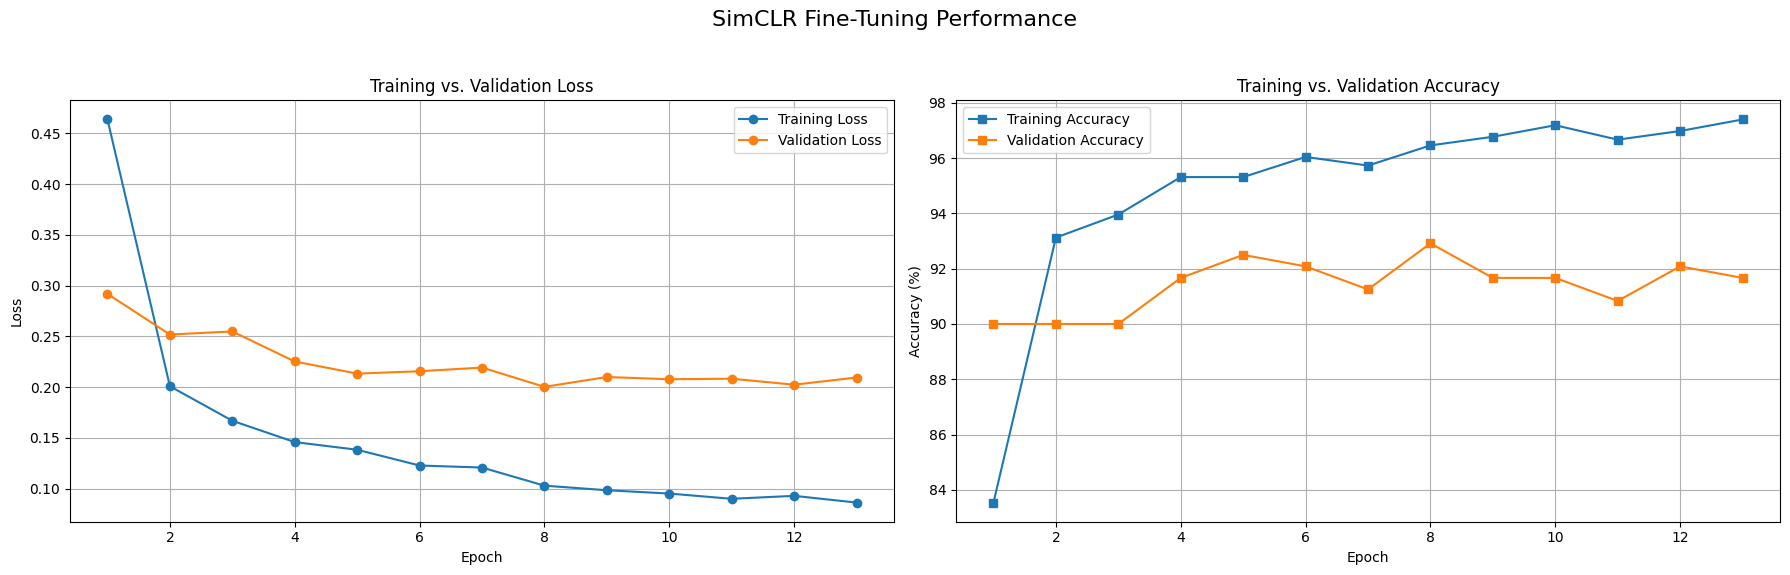

In [17]:
# --- Plotting Results ---
epochs_ran = len(downstream_losses)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('SimCLR Fine-Tuning Performance', fontsize=16)

# Loss Curves
ax1.plot(range(1, epochs_ran + 1), downstream_losses, marker='o', linestyle='-', label='Training Loss')
ax1.plot(range(1, epochs_ran + 1), val_losses, marker='o', linestyle='-', label='Validation Loss')
ax1.set_title('Training vs. Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy Curves
ax2.plot(range(1, epochs_ran + 1), downstream_accuracies, marker='s', linestyle='-', label='Training Accuracy')
ax2.plot(range(1, epochs_ran + 1), val_accuracies, marker='s', linestyle='-', label='Validation Accuracy')
ax2.set_title('Training vs. Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()